In [1]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
from biosppy.signals import ecg, tools


import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim import Adam
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib

# Data Load (using WFDB)

In [4]:
pickle_path = "./mit_pickle"

In [5]:
def record_extract(input_path):
    records = open(input_path+"RECORDS","r")
    records_list = []
    for l in records:
        l = l.rstrip()
        records_list.append(l)
    records.close()
    return records_list

In [6]:
#data extract from Physionet

input_path = "./physionet/mit-bih_arr/1.0.0/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
    records_list.append(l)
records.close()
print(records_list)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [7]:
NORMAL_ANN = ['N', 'L', 'R', 'e', 'j']
SUPRA_ANN = ['A', 'a', 'J', 'S']
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

In [8]:
hb = ecg.extract_heartbeats(signal=record_sig[0][:,0], rpeaks=record_ann, sampling_rate=360,before=0.3,after=0.3)

NameError: name 'record_sig' is not defined

In [9]:
rpeaks_ch = ecg.christov_segmenter(signal=record_sig[0][:,0], sampling_rate=360)

NameError: name 'record_sig' is not defined

In [10]:
rpeaks_ha = ecg.hamilton_segmenter(signal=record_sig[0][:,0], sampling_rate=360)

NameError: name 'record_sig' is not defined

In [11]:
comp = ecg.compare_segmentation(rpeaks_ha["rpeaks"],record_ann,sampling_rate=360)

NameError: name 'rpeaks_ha' is not defined

In [151]:
count = 0
for i in comp["match"]:
    if i == count:
        pass
    else:
        print("Missing match I,",i,count)
    count+=1

In [198]:
len(beat["Beats"]),len(beat["rpeaks"])

(2272, 2272)

In [202]:
beat["symbol"]=record_ann_sym[:-1]

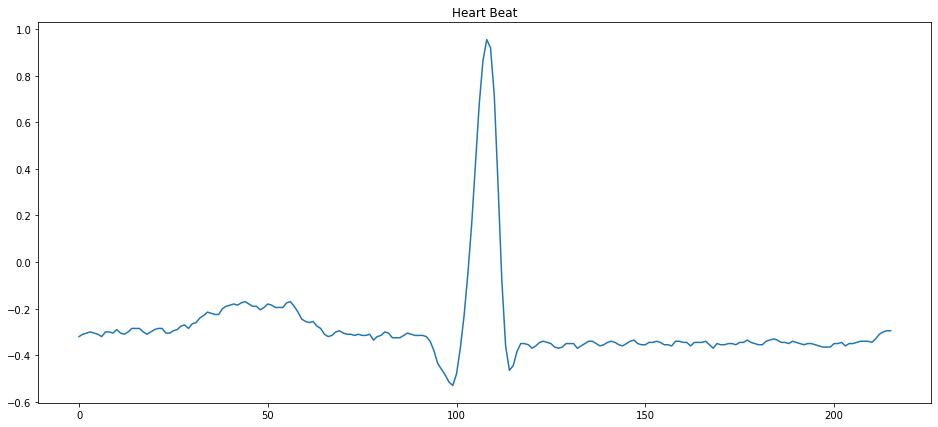

In [212]:
from sklearn import MinMaxScaler as mms
beat[""]

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(1,1,1)
ax.set_title("Heart Beat")
ax.plot(beat["Beats"][1080])

In [12]:
window_size = 320
def extract_from_sbj(idx):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=0)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr", sampfrom=0).sample)[1:]
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr", sampfrom=0).symbol)[1:]
    interval = wp.ann2rr(input_path+records_list[idx], "atr", as_array=True)
    
    rpeaks_ch = ecg.christov_segmenter(signal=record_sig[0][:,0], sampling_rate=360)
    rpeaks_ha = ecg.hamilton_segmenter(signal=record_sig[0][:,0], sampling_rate=360)
    
    #h_beat = ecg.extract_heartbeats(signal=record_sig[0][:,0], rpeaks=rpeaks_ha, sampling_rate=360)
    NORMAL_ANN = ['N', 'L', 'R', 'e', 'j']
    SUPRA_ANN = ['A', 'a', 'J', 'S']
    VENTRI_ANN = ['V', 'E']
    FUSION_ANN = ['F']
    UNCLASS_ANN = ['/', 'f', 'Q']
    
    for i,sym in enumerate(record_ann_sym):
        if sym in NORMAL_ANN:
            record_ann_sym[i] = "N"
        elif sym in SUPRA_ANN:
            record_ann_sym[i] = "S"
        elif sym in VENTRI_ANN:
            record_ann_sym[i] = "V"
        elif sym in FUSION_ANN:
            record_ann_sym[i] = "F"
        elif sym in UNCLASS_ANN:
            record_ann_sym[i] = "Q"
        else:
            record_ann_sym[i] = " "
    
    def beat_Padding(beat,w_size):
        beat_len = len(beat)
        if beat_len <= w_size:
            pd_size = (w_size - beat_len)//2
        pad_beat = np.pad(beat, (pd_size, pd_size), "constant", constant_values=0)
        
        if len(pad_beat) < w_size:
            pad_beat = np.pad(pad_beat, (0, w_size - len(pad_beat)), "constant", constant_values=0)
        elif len(pad_beat) > w_size:
            pad_beat = pad_beat[0:-(len(pad_beat)-w_size)]
        
        
        return pad_beat
    
    def beat_extraction(signal,rpeaks): # Peak를 기점으로 앞뒤로 0.3초 정도의 window를 가지는 Beat들
        beat = []
        for i,rp in enumerate(rpeaks):
            if i == 0: # 0.3초 정도의 window
                start = int(rp-(0.3*360))
                if start < 0:
                    start = 0
                end = int(rp+(0.3*360))
                sig_beat = beat_Padding(signal[start:end], window_size)
                beat.append(sig_beat)
                continue
            
            # 양쪽으로 30% 정도 남겨서 짜르기
            
            start = int(rp-(0.3 * 360))
            end = int(rp+(0.3 * 360))
            
            if end > len(signal):
                end = len(signal-1)
                
            # Beat Padding
            sig_beat = beat_Padding(signal[start:end], window_size)
            beat.append(sig_beat)

        return {"Beats":beat,"rpeaks":rpeaks, "symbol":record_ann}
    
    beat = beat_extraction(record_sig[0][:,0], record_ann)
    
    print("Beats, Rpeaks Len, ",len(beat["Beats"]),len(beat["rpeaks"]), len(record_ann))
    
    beat["symbol"]=record_ann_sym[:-1]
    max_len = -1
    min_len = 9999
    for i,datas in enumerate(zip(beat["rpeaks"],beat["symbol"])):
        max_len = max(max_len, len(beat["Beats"][i]))
        min_len = min(min_len, len(beat["Beats"][i]))
    return max_len, min_len, beat

datas = {}

for i,rec in enumerate(records_list):
    print("Record",rec)
    maxs, mins, beats = extract_from_sbj(i)
    datas[rec]=beats
    print(maxs,mins)

Record 100
Beats, Rpeaks Len,  2273 2273 2273
320 320
Record 101
Beats, Rpeaks Len,  1873 1873 1873
320 320
Record 102
Beats, Rpeaks Len,  2191 2191 2191
320 320
Record 103
Beats, Rpeaks Len,  2090 2090 2090
320 320
Record 104
Beats, Rpeaks Len,  2310 2310 2310
320 320
Record 105
Beats, Rpeaks Len,  2690 2690 2690
320 320
Record 106
Beats, Rpeaks Len,  2097 2097 2097
320 320
Record 107
Beats, Rpeaks Len,  2139 2139 2139
320 320
Record 108
Beats, Rpeaks Len,  1823 1823 1823
320 320
Record 109
Beats, Rpeaks Len,  2534 2534 2534
320 320
Record 111
Beats, Rpeaks Len,  2132 2132 2132
320 320
Record 112
Beats, Rpeaks Len,  2549 2549 2549
320 320
Record 113
Beats, Rpeaks Len,  1795 1795 1795
320 320
Record 114
Beats, Rpeaks Len,  1889 1889 1889
320 320
Record 115
Beats, Rpeaks Len,  1961 1961 1961
320 320
Record 116
Beats, Rpeaks Len,  2420 2420 2420
320 320
Record 117
Beats, Rpeaks Len,  1538 1538 1538
320 320
Record 118
Beats, Rpeaks Len,  2300 2300 2300
320 320
Record 119
Beats, Rpeaks Len

In [15]:
pickle_path = "./mit_pickle"

In [16]:
# Save pickle File

import pickle

for rec in records_list:
    pickle_data = pickle_path + "/" + rec + ".pkl"
    with open(pickle_data,"wb") as f:
        pickle.dump(datas[rec], f, pickle.HIGHEST_PROTOCOL)

### Model




In [2]:
# Interpretation of Electrocardiogram Heartbeat by CNN and GRU (not Use)
class LFEM(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size):
        super(LFEM, self).__init__()
        
        self.lfem_seq = nn.Sequential(
            nn.Conv1d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=1, padding="same"),
            nn.BatchNorm1d(out_channel),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
    
    def forward(self, x):
        return self.lfem_seq(x)

class LFEM_Stack(nn.Module):
    def __init__(self, num_layer=6):
        super(LFEM_Stack, self).__init__()
        
        self.num_layer = num_layer
        self.lfem_list = []
        layer_size=[64,64,128,128,256,256]
        for i in range(num_layer-1):
            self.lfem_list.append(LFEM(in_channel=layer_size[i], out_channel=layer_size[i+1], kernel_size=3))
        self.lfem_list.append(LFEM(in_channel=layer_size[5], out_channel=layer_size[5], kernel_size=3))
            
    def forward(self, x):
        for i in range(self.num_layer):
            x = self.lfem_list[i](x)
            
        return x
    

In [3]:
class conv_gru(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(conv_gru, self).__init__()
        
        #input Layer
        self.input_Seq1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channel, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.input_Seq2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.input_Seq3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.input_Seq4 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding="same"),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
#         self.lfem_module = LFEM_Stack(6)
        # reshape
        # dropout
        # gru
        # dense 1
        # dense 2
        self.dropout = nn.Dropout(0.3)
        self.gru = nn.GRU(input_size=256, hidden_size=512 ,num_layers=2, bidirectional=True)
        self.dense1 = nn.Linear(512,256)
        self.dense2 = nn.Linear(256,out_channel)
        
    def forward(self, x):
        
        x = self.input_Seq1(x)
        x = self.input_Seq2(x)
        x = self.input_Seq3(x)
        x = self.input_Seq4(x)
        x = self.dropout(x)
        x = self.gru(x)
        x = self.dense1(x)
        x = self.dense2(x)
        print(x.shape)
        return x

In [4]:
def train(train_data):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = conv_gru(in_channel=1,out_channel=5)
    print(model)

In [5]:
model = conv_gru(in_channel=1,out_channel=5)
print(model)

conv_gru(
  (input_Seq1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (input_Seq2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (input_Seq3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (input_Seq4): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (gru): GRU(256, 512, num_layers=2, bidirectional=True)
  (dense1): Linear(in_features=512, out_features=256, bias=Tru

In [30]:
# Data Loader
summary(model)
print()

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       128
|    └─BatchNorm1d: 2-2                  64
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─Conv1d: 2-4                       6,208
|    └─BatchNorm1d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-3                        --
|    └─Conv1d: 2-7                       24,704
|    └─BatchNorm1d: 2-8                  256
|    └─ReLU: 2-9                         --
├─Sequential: 1-4                        --
|    └─Conv1d: 2-10                      98,560
|    └─BatchNorm1d: 2-11                 512
|    └─ReLU: 2-12                        --
├─Dropout: 1-5                           --
├─GRU: 1-6                               7,090,176
├─Linear: 1-7                            131,328
├─Linear: 1-8                            1,285
Total params: 7,353,349
Trainable params:

In [31]:
# Data Loader

trainloader